In [39]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import datetime


def get_rendements(stocks,début,fin): #date=yyyy-mm-dd en string
    prix=pdr.get_data_yahoo(stocks,start=début,end=fin)['Close'] 
    returns=prix.pct_change()
    logrdt=np.log(1+returns)*100
    logrdt=logrdt.iloc[1:]
    returns=returns.iloc[1:]
    prix=prix.iloc[1:]
    return  returns, prix, logrdt

stocks=['AAPL','AXP','BA', 'CAT', 'CSCO', 'CVX','DD','DIS','GE','HD','HPQ','IBM','INTC','JNJ','JPM','KO','MCD','MMM','MRK','MSFT','NKE','PFE','PG','RTX','T','TRV','UNH','VZ','WMT','XOM']
début='2000-01-02'
fin='2014-12-31'

output=get_rendements(stocks, début, fin)
rendements=output[0]
prix=output[1]
rdt_log=output[2]

C:\Users\baptc\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.


In [62]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import datetime





def Tick_Loss(u,alpha):
    """
    Fonction de perte aymétrique et par morceaux de Giacomini et Komunjer (2005)
    """ 
    
    if u<=0:
        y=1
    else:
        y=0
        
    return (alpha-y)*u  



def Inverse_Rank(M_previsions,rdt,alpha=0.01):
    """
   Inverse rank de Timmermann(2006)
    """
    
    # Calcul du nombre de lignes
    t=M_previsions.shape[0]
    # Calcul du nombre de colonnes
    M=M_previsions.shape[1]
    # Creation de la matrice des Betas de chaque date, pour chaque méthode
    beta_weight=np.zeros((t,M))
    
    
    # Création d'une matrice contenant les pertes de tick des différents modèles de VaR
    tick_losses=np.zeros((t,M))

    # Boucle attribuant un poids aux modèles proportionnelement à leurs pertes pour la période 0
    for i in range(0,M):
            tick_losses[0,i]=Tick_Loss(rdt.iloc[0]-M_previsions.iloc[0,i],alpha)
    
    
    # Détermination du classement de chaques modèle en fonction des pertes
    # Le modèle avec la perte la plus faible sera le mieux classé
    argsort_array=(tick_losses[0,:]).argsort()
    ranks_array = np.empty_like(argsort_array)
    ranks_array[argsort_array] = np.arange(M)
    ranking_inverse=np.zeros(M)
   
    # Boucle attribuant un poids aux modèles proportionnelement à leurs pertes pour la période 0
    for i in ranks_array:
        if (ranks_array[i]+1)>0:
            ranking_inverse[i]=1/(ranks_array[i]+1)
        else:
            ranking_inverse[i]=0
     
   
    # Calcul de la la somme totale du classement inverse des modèles
    sum_ranking_inverse=np.sum(ranking_inverse)
   
    # Calcul du Beta des modèles
    beta_weight[0,:]=np.divide(ranking_inverse,sum_ranking_inverse)
    
 
    
    # Calcul de la perte par rapport aux réalisations du portefeuille
    for j in range(1,t):
        for i in range(0,M):
            tick_losses[j,i]=tick_losses[j-1,i]+Tick_Loss(rdt.iloc[j]-M_previsions.iloc[j,i],alpha)
            
        argsort_array=(tick_losses[j,:]).argsort()
        ranks_array = np.empty_like(argsort_array)
        ranks_array[argsort_array] = np.arange(M)
        ranking_inverse=np.zeros(M)
        
        # Boucle attribuant un poids aux modèles proportionnelement à leurs pertes
        for k in ranks_array:
            if (ranks_array[k]+1)>0:
                ranking_inverse[k]=1/(ranks_array[k]+1)
            else:
                ranking_inverse[k]=0
     

        # Calcul de la la somme totale du classement inverse des modèles
        sum_ranking_inverse=np.sum(ranking_inverse)
    
        # Calcul du Beta des modèles
        beta_weight[j,:]=np.divide(ranking_inverse,sum_ranking_inverse)    
            
            
    return beta_weight

In [63]:
from pandas import*

VaR_Inverse_Rank=np.zeros((3771,30))

for i in range(0,30):
    mypath='{}/Assets/models_asset_{}.csv'.format(path,i)
    file=read_csv(mypath)
    
    
    Beta=Inverse_Rank(file.iloc[1:3773,1:18], rdt_log.iloc[:,i],alpha=0.01)

    valeur=np.zeros((3772,18))
    valeur=file.iloc[0:3772,1:18]

    VaR=np.multiply(Beta[1:3772,:],valeur.iloc[1:3772,:])
    
    
    VaR_Inverse_Rank[:,i]=VaR.sum(axis=1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [64]:
import numpy as np



    
VaR_Inverse_Rank_Results=DataFrame(VaR_Inverse_Rank[1758:3771],index=file['dates'].iloc[1759:3772],columns=stocks)

In [46]:
# même principe pour le reste 
# name correspond au nom de la méthode utilisé
def kupiec(var_1,rdt_log_1,var_2,rdt_log_2,var_3,rdt_log_3,name):
    
    '''c'est la partie 1 du graphique'''
    var=var_1
    rdt_log=rdt_log_1
    
    resu=[]
    p_un=rdt_log.shape[0]
    for j in range(0,len(rdt_log.columns)): #on s'interesse à tous les actifs
        rdt_logs=rdt_log.iloc[:,j]
        var_s=var.iloc[:,j]
        a=0
        for i in range(0,p_un):
            varr=var_s.iloc[i]
            rdt=rdt_logs.iloc[i]

            g_rdt=float(rdt)
            g_var=float(varr)
            #pour savoir si la Var a joué son rôle ou pas
            if g_var>g_rdt:
                a=a+1

        final=a/p_un
        resu.append(final)
    
    val=resu
    
    values=np.ones(len(rdt_log.columns))*0.005 #ici c'est pour tous les actifs
    plt.figure(figsize=(10, 0.5))
    un=plt.subplot(1,3,1)
    plt.scatter(val, values, s=20)
    plt.xticks([0.01,0.02,0.03])
    plt.yticks([])
    plt.xlim(0, 0.04)
    plt.ylim(0, 0.01)
    plt.axvline(x=0.01-2.58*(0.01*0.99/p_un)**0.5,color='black')
    plt.axvline(x=0.01+2.58*(0.01*0.99/p_un)**0.5,color='black')
    plt.axvline(x=0.01,color='grey')
    plt.title('période du 03.01.2007 au 31.12.2014',fontsize=8)
    plt.ylabel(name, fontsize=8)
    
    '''c'est la partie 2 du graphique'''
    #c'est quasiement le même code que pour la première partie du graphique
    var=var_2
    rdt_log=rdt_log_2
    
    resu=[]
    p_un=rdt_log.shape[0]
    for j in range(0,len(rdt_log.columns)): 
        rdt_logs=rdt_log.iloc[:,j]
        
        var_s=var.iloc[:,j]
        a=0
        for i in range(0,p_un):
            varr=var_s.iloc[i]
            rdt=rdt_logs.iloc[i]

            g_rdt=float(rdt)
            g_var=float(varr)
            
            if g_var>g_rdt:
                a=a+1

        final=a/p_un
        resu.append(final)
    val=resu
    values=np.ones(len(rdt_log.columns))*0.005 


    deux=plt.subplot(1,3,2)
    plt.scatter(val, values, s=20)
    plt.xticks([0.01,0.02,0.03])
    plt.yticks([])
    plt.xlim(0, 0.04)
    plt.ylim(0, 0.01)
    plt.axvline(x=0.01-2.58*(0.01*0.99/p_un)**0.5,color='black')
    plt.axvline(x=0.01+2.58*(0.01*0.99/p_un)**0.5,color='black')
    plt.axvline(x=0.01,color='grey')
    plt.title('période du 03.01.2007 au 31.12.2010',fontsize=8)
    
    
    var=var_3
    rdt_log=rdt_log_3
    
    resu=[]
    p_un=rdt_log.shape[0]
    for j in range(0,len(rdt_log.columns)): 
        rdt_logs=rdt_log.iloc[:,j]
        
        var_s=var.iloc[:,j]
        a=0
        for i in range(0,p_un):
            varr=var_s.iloc[i]
            rdt=rdt_logs.iloc[i]

            g_rdt=float(rdt)
            g_var=float(varr)
            
            if g_var>g_rdt:
                a=a+1
        final=a/p_un
        resu.append(final)
    val=resu
    
    
    '''c'est la partie 3 du graphique'''
    values=np.ones(len(rdt_log.columns))*0.005 

    trois=plt.subplot(1,3,3)
    plt.scatter(val, values, s=20)
    plt.xticks([0.01,0.02,0.03])
    plt.yticks([])
    plt.xlim(0, 0.04)
    plt.ylim(0, 0.01)
    plt.axvline(x=0.01-2.58*(0.01*0.99/p_un)**0.5,color='black')
    plt.axvline(x=0.01+2.58*(0.01*0.99/p_un)**0.5,color='black')
    plt.axvline(x=0.01,color='grey')
    plt.title('période du 03.01.2011 au 31.12.2014',fontsize=8)

    
    plt.show()

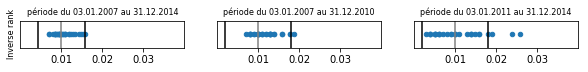

In [65]:
import matplotlib.pyplot as plt

kupiec(VaR_Inverse_Rank_Results,rdt_log.iloc[1758:3771:,:],VaR_Inverse_Rank_Results,rdt_log.iloc[1758:2766,:],VaR_Inverse_Rank_Results,rdt_log.iloc[2767:3771,:],"Inverse rank")

In [66]:
VaR_Inverse_Rank_Results.to_csv("Inverse rank Results 2007-2014.csv")